# Final Project Applying NLP

## Project Description: 
Sentiment analysis: the sentiment of the textual data will be analyzed and classified into at least 3 classes.

### 1. Data Collection 

#### 1.1 Collect a dataset of product reviews

- Source data: https://www.kaggle.com/code/mehmetisik/rating-product-sorting-reviews-in-amazon/input

#### 1.2 Annotate the dataset

- With labels of positive, negative or neutral sentiment, based on
collected data

In [74]:
import pandas as pd

# Load the CSV file
file_path = "./data/reviews_aws/amazon_review.csv"
try:
    data = pd.read_csv(file_path)
except FileNotFoundError:
    print(f"Error: File not found at {file_path}")
    exit()

# Verify that the 'overall' column exists and is numeric
if 'overall' not in data.columns:
    print("Error: 'overall' column is missing in the dataset.")
    exit()
if not pd.api.types.is_numeric_dtype(data['overall']):
    print("Error: 'overall' column must contain numeric data.")
    exit()

# Function to label sentiment
def label_sentiment(overall):
    if overall >= 4:
        return "Positive"
    elif overall == 3:
        return "Neutral"
    else:
        return "Negative"

# Add sentiment labels
data['sentiment'] = data['overall'].apply(label_sentiment)

# Save the updated file
output_path = "./data/reviews_aws/amazon_review_labeled.csv"
data.to_csv(output_path, index=False)

# Print confirmation
print(f"Labeled file saved at: {output_path}")
data.head()  # Display the first few rows of the updated dataset



Labeled file saved at: ./data/reviews_aws/amazon_review_labeled.csv


,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,day_diff,helpful_yes,total_vote,sentiment
0,A3SBTW3WS4IQSN,B007WTAJTO,NaN,"[0, 0]",No issues.,4.0,Four Stars,1406073600,2014-07-23,138,0,0,Positive
1,A18K1ODH1I2MVB,B007WTAJTO,0mie,"[0, 0]","Purchased this for my device, it worked as adv...",5.0,MOAR SPACE!!!,1382659200,2013-10-25,409,0,0,Positive
2,A2FII3I2MBMUIA,B007WTAJTO,1K3,"[0, 0]",it works as expected. I should have sprung for...,4.0,nothing to really say....,1356220800,2012-12-23,715,0,0,Positive
3,A3H99DFEG68SR,B007WTAJTO,1m2,"[0, 0]",This think has worked out great.Had a diff. br...,5.0,Great buy at this price!!! *** UPDATE,1384992000,2013-11-21,382,0,0,Positive
4,A375ZM4U047O79,B007WTAJTO,2&amp;1/2Men,"[0, 0]","Bought it with Retail Packaging, arrived legit...",5.0,best deal around,1373673600,2013-07-13,513,0,0,Positive


In [50]:
import torch
x = torch.rand(5, 3)
print(x)

tensor([[0.7671, 0.7578, 0.6659],
        [0.2782, 0.6108, 0.7596],
        [0.7764, 0.3242, 0.6786],
        [0.1795, 0.2656, 0.6990],
        [0.3536, 0.8867, 0.3101]])


In [4]:
import pandas as pd
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import pipeline
import torch
from tqdm import tqdm

def setup_sentiment_analyzer():
    # Set up model and tokenizer
    model = BertForSequenceClassification.from_pretrained(
        "ahmedrachid/FinancialBERT-Sentiment-Analysis",
        num_labels=3
    )
    tokenizer = BertTokenizer.from_pretrained(
        "ahmedrachid/FinancialBERT-Sentiment-Analysis"
    )
    return pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)

def clean_text(text):
    # Clean and preprocess text
    if isinstance(text, str):
        # Remove very long texts that might cause issues
        if len(text) > 512:
            text = text[:512]
        return text
    return ""

def analyze_sentiments(df, text_column='reviewText', batch_size=32):
    # Initialize sentiment analyzer
    nlp = setup_sentiment_analyzer()
    
    # Create lists for results
    sentiments = []
    scores = []
    
    # Get all non-null reviews and clean them
    texts = df[text_column].dropna().apply(clean_text).tolist()
    
    # Process reviews in batches with progress bar
    for i in tqdm(range(0, len(texts), batch_size)):
        batch = texts[i:i + batch_size]
        try:
            # Filter out empty strings
            valid_texts = [text for text in batch if text.strip()]
            if valid_texts:
                results = nlp(valid_texts)
                # Map the results back to the original batch size
                for j in range(len(batch)):
                    if j < len(results):
                        sentiments.append(results[j]['label'])
                        scores.append(results[j]['score'])
                    else:
                        # For any skipped texts, use the neutral sentiment
                        sentiments.append('neutral')
                        scores.append(0.5)
        except Exception as e:
            print(f"Error processing batch starting at index {i}: {e}")
            # Use neutral sentiment for failed batches
            sentiments.extend(['neutral'] * len(batch))
            scores.extend([0.5] * len(batch))
    
    # Create new DataFrame with sentiment analysis results
    result_df = df.copy()
    result_df['sentiment'] = pd.NA
    result_df['sentiment_score'] = pd.NA
    
    # Update only rows with non-null reviewText
    valid_indices = df[text_column].dropna().index
    result_df.loc[valid_indices, 'sentiment'] = sentiments
    result_df.loc[valid_indices, 'sentiment_score'] = scores
    
    return result_df

# Main execution with error handling
try:
    # 1. Load data
    print("Loading data...")
    df = pd.read_csv('./data/reviews_aws/amazon_review.csv')
    
    # 2. Run sentiment analysis
    print("Starting sentiment analysis...")
    result_df = analyze_sentiments(df, text_column='reviewText', batch_size=32)
    
    # 3. Save results
    result_df.to_csv('amazon_reviews_with_sentiment.csv', index=False)
    
    # 4. Display result statistics
    print("\nSentiment Distribution:")
    print(result_df['sentiment'].value_counts())
    print("\nAverage Sentiment Scores:")
    print(result_df.groupby('sentiment')['sentiment_score'].mean())
    
except Exception as e:
    print(f"An error occurred: {e}")

Loading data...
Starting sentiment analysis...


Device set to use cpu
100%|██████████| 154/154 [09:37<00:00,  3.75s/it]


Sentiment Distribution:
sentiment
neutral     3768
positive    1044
negative     102
Name: count, dtype: int64

Average Sentiment Scores:
sentiment
negative    0.833625
neutral     0.974982
positive    0.936555
Name: sentiment_score, dtype: object


### 2 Preprocessing

- Perform necessary text preprocessing steps such as tokenization, stop-word removal,
stemming/lemmatization, and lowercasing. (10)
- Remove any irrelevant columns, handle missing values, and clean text data by removing
special characters, stopwords, and performing stemming/lemmatization.
- Handle specific challenges of used text like hashtags, emojis, and slang.

In [75]:
import pandas as pd
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# Download necessary NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')


[nltk_data] Downloading package punkt to /Users/marieth/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/marieth/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/marieth/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /Users/marieth/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [26]:
data = pd.read_csv("amazon_reviews_with_sentiment.csv")
data

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,day_diff,helpful_yes,total_vote,sentiment,sentiment_score
0,A3SBTW3WS4IQSN,B007WTAJTO,NaN,"[0, 0]",No issues.,4.0,Four Stars,1406073600,2014-07-23,138,0,0,neutral,0.999660
1,A18K1ODH1I2MVB,B007WTAJTO,0mie,"[0, 0]","Purchased this for my device, it worked as adv...",5.0,MOAR SPACE!!!,1382659200,2013-10-25,409,0,0,neutral,0.999040
2,A2FII3I2MBMUIA,B007WTAJTO,1K3,"[0, 0]",it works as expected. I should have sprung for...,4.0,nothing to really say....,1356220800,2012-12-23,715,0,0,positive,0.998226
3,A3H99DFEG68SR,B007WTAJTO,1m2,"[0, 0]",This think has worked out great.Had a diff. br...,5.0,Great buy at this price!!! *** UPDATE,1384992000,2013-11-21,382,0,0,positive,0.998094
4,A375ZM4U047O79,B007WTAJTO,2&amp;1/2Men,"[0, 0]","Bought it with Retail Packaging, arrived legit...",5.0,best deal around,1373673600,2013-07-13,513,0,0,neutral,0.587625
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4910,A2LBMKXRM5H2W9,B007WTAJTO,"ZM ""J""","[0, 0]",I bought this Sandisk 16GB Class 10 to use wit...,1.0,Do not waste your money.,1374537600,2013-07-23,503,0,0,neutral,0.835334
4911,ALGDLRUI1ZPCS,B007WTAJTO,Zo,"[0, 0]",Used this for extending the capabilities of my...,5.0,Great item!,1377129600,2013-08-22,473,0,0,positive,0.999684
4912,A2MR1NI0ENW2AD,B007WTAJTO,Z S Liske,"[0, 0]",Great card that is very fast and reliable. It ...,5.0,Fast and reliable memory card,1396224000,2014-03-31,252,0,0,neutral,0.999430
4913,A37E6P3DSO9QJD,B007WTAJTO,Z Taylor,"[0, 0]",Good amount of space for the stuff I want to d...,5.0,Great little card,1379289600,2013-09-16,448,0,0,neutral,0.999711


**Perform necessary text preprocessing steps such as tokenization, stop-word removal,
stemming/lemmatization, and lowercasing.**

In [27]:
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Initialize lemmatizer
lemmatizer = WordNetLemmatizer()

# Define stopwords
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    if not isinstance(text, str):  # Check if the value is not a string
        return ""  # Return an empty string or handle it as needed
    # Convert to lowercase
    text = text.lower()
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Tokenize
    tokens = word_tokenize(text)
    # Remove stopwords and lemmatize
    processed_tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    # Join tokens back into a single string
    return ' '.join(processed_tokens)

# Fill NaN values in the 'reviewText' column
data['reviewText'] = data['reviewText'].fillna("")

# Apply the preprocessing function
data['processed_review'] = data['reviewText'].apply(preprocess_text)

# Check the first few rows
data.head()



,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,day_diff,helpful_yes,total_vote,sentiment,sentiment_score,processed_review
0,A3SBTW3WS4IQSN,B007WTAJTO,NaN,"[0, 0]",No issues.,4.0,Four Stars,1406073600,2014-07-23,138,0,0,neutral,0.999660,issue
1,A18K1ODH1I2MVB,B007WTAJTO,0mie,"[0, 0]","Purchased this for my device, it worked as adv...",5.0,MOAR SPACE!!!,1382659200,2013-10-25,409,0,0,neutral,0.999040,purchased device worked advertised never much ...
2,A2FII3I2MBMUIA,B007WTAJTO,1K3,"[0, 0]",it works as expected. I should have sprung for...,4.0,nothing to really say....,1356220800,2012-12-23,715,0,0,positive,0.998226,work expected sprung higher capacity think mad...
3,A3H99DFEG68SR,B007WTAJTO,1m2,"[0, 0]",This think has worked out great.Had a diff. br...,5.0,Great buy at this price!!! *** UPDATE,1384992000,2013-11-21,382,0,0,positive,0.998094,think worked greathad diff bran 64gb card went...
4,A375ZM4U047O79,B007WTAJTO,2&amp;1/2Men,"[0, 0]","Bought it with Retail Packaging, arrived legit...",5.0,best deal around,1373673600,2013-07-13,513,0,0,neutral,0.587625,bought retail packaging arrived legit orange e...


**Drop irrelevant columns**

In [28]:
# Drop irrelevant columns
irrelevant_columns = ['reviewerID', 'asin', 'reviewerName', 'helpful', 'unixReviewTime', 
                      'reviewTime', 'day_diff', 'summary', 'helpful_yes', 'total_vote']
data = data.drop(columns=irrelevant_columns, errors='ignore')


**Count missing values in specific columns**

In [32]:
# Count missing values in specific columns
missing_values = data[['processed_review', 'overall','sentiment','sentiment_score']].isnull().sum()
data = data.dropna(subset=['sentiment', 'sentiment_score'])
# Display the result
print("Missing values in each column:")
print(missing_values)


Missing values in each column:
processed_review    0
overall             0
sentiment           0
sentiment_score     0
dtype: int64


**Clean text data by removing
special characters, stopwords, and performing stemming/lemmatization.**

In [33]:
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer

# Initialize stopwords and stemmer
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()

def preprocess_text(text):
    if not isinstance(text, str):  # Handle non-string values
        return ""
    
    # Convert to lowercase
    text = text.lower()
    
    # Remove special characters and numbers
    text = re.sub(r'[^a-z\s]', '', text)
    
    # Tokenize
    tokens = word_tokenize(text)
    
    # Remove stopwords and apply stemming
    processed_tokens = [stemmer.stem(word) for word in tokens if word not in stop_words]
    
    # Join tokens back into a single string
    return ' '.join(processed_tokens)

# Apply text preprocessing to 'reviewText'
data['processed_review'] = data['reviewText'].apply(preprocess_text)
####
data['processed_review']

0                                                    issu
1       purchas devic work advertis never much phone m...
2       work expect sprung higher capac think made bit...
3       think work greathad diff bran gb card went sou...
4       bought retail packag arriv legit orang envelop...
                              ...                        
4910    bought sandisk gb class use htc inspir month g...
4911    use extend capabl samsung galaxi note greatli ...
4912    great card fast reliabl come option adapt sd s...
4913           good amount space stuff want fit gopro say
4914    ive heard bad thing gb micro sd card crap week...
Name: processed_review, Length: 4914, dtype: object

**Handle specific challenges of used text like hashtags, emojis, and slang.**

In [35]:
from wordsegment import load, segment

# Load wordsegment model
load()

def handle_hashtags(text):
    # Identify hashtags
    hashtags = re.findall(r"#\w+", text)
    for hashtag in hashtags:
        # Split hashtag into words
        words = " ".join(segment(hashtag[1:]))  # Remove '#' and segment
        text = text.replace(hashtag, words)
    return text


In [36]:
import emoji

def handle_emojis(text):
    # Replace emojis with their descriptions (e.g., 😊 -> ":smiling_face_with_smiling_eyes:")
    text = emoji.demojize(text, delimiters=(" ", " "))
    return text


In [37]:
# Example slang dictionary
slang_dict = {
    "u": "you",
    "ur": "your",
    "omg": "oh my god",
    "btw": "by the way",
    "idk": "I don't know",
}

def handle_slang(text):
    # Replace slang words with their standard equivalents
    words = text.split()
    replaced_words = [slang_dict.get(word.lower(), word) for word in words]
    return " ".join(replaced_words)


In [38]:
def preprocess_text_with_challenges(text):
    if not isinstance(text, str):
        return ""
    
    # Handle hashtags
    text = handle_hashtags(text)
    
    
    # Handle emojis
    text = handle_emojis(text)
    
    # Handle slang
    text = handle_slang(text)
    
    # Lowercase the text
    text = text.lower()
    
    # Remove special characters and numbers
    text = re.sub(r"[^a-z\s]", "", text)
    
    # Tokenize
    tokens = word_tokenize(text)
    
    # Remove stopwords and apply stemming
    processed_tokens = [stemmer.stem(word) for word in tokens if word not in stop_words]
    
    # Join tokens back into a single string
    return " ".join(processed_tokens)

# Apply the combined preprocessing to 'reviewText'
print(data.head)
data['processed_review'] = data['reviewText'].apply(preprocess_text_with_challenges)
data.head()



<bound method NDFrame.head of                                              reviewText  overall sentiment  \
0                                            No issues.      4.0   neutral   
1     Purchased this for my device, it worked as adv...      5.0   neutral   
2     it works as expected. I should have sprung for...      4.0  positive   
3     This think has worked out great.Had a diff. br...      5.0  positive   
4     Bought it with Retail Packaging, arrived legit...      5.0   neutral   
...                                                 ...      ...       ...   
4910  I bought this Sandisk 16GB Class 10 to use wit...      1.0   neutral   
4911  Used this for extending the capabilities of my...      5.0  positive   
4912  Great card that is very fast and reliable. It ...      5.0   neutral   
4913  Good amount of space for the stuff I want to d...      5.0   neutral   
4914  I've heard bad things about this 64gb Micro SD...      5.0  negative   

      sentiment_score            

,reviewText,overall,sentiment,sentiment_score,processed_review
0,No issues.,4.0,neutral,0.999660,issu
1,"Purchased this for my device, it worked as adv...",5.0,neutral,0.999040,purchas devic work advertis never much phone m...
2,it works as expected. I should have sprung for...,4.0,positive,0.998226,work expect sprung higher capac think made bit...
3,This think has worked out great.Had a diff. br...,5.0,positive,0.998094,think work greathad diff bran gb card went sou...
4,"Bought it with Retail Packaging, arrived legit...",5.0,neutral,0.587625,bought retail packag arriv legit orang envelop...


### 3. Feature Extraction and Model Comparison

#### 3.1 Explore different feature representation methods 
such as bag-of-words, TF-IDF, word embeddings (e.g., Word2Vec or GloVe), or contextual embeddings (e.g., BERT or GPT).
Experiment with 3 different feature extraction techniques to capture meaningful
representations of social media text where the 3 techniques should be of different
word embedding categories

##### 3.1.1 TF-IDF Representation

In [40]:
from sklearn.feature_extraction.text import TfidfVectorizer
print(data)
# Initialize the TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=1000)  # You can adjust max_features

# Fit and transform the 'processed_review' column
tfidf_features = tfidf_vectorizer.fit_transform(data['processed_review'].fillna('')).toarray()

# Convert to DataFrame for better visualization
import pandas as pd
tfidf_df = pd.DataFrame(tfidf_features, columns=tfidf_vectorizer.get_feature_names_out())

# Add TF-IDF features to the original dataset (optional)
data = pd.concat([data.reset_index(drop=True), tfidf_df.reset_index(drop=True)], axis=1)
print(tfidf_features)
data.head(5)

                                             reviewText  overall sentiment  \
0                                            No issues.      4.0   neutral   
1     Purchased this for my device, it worked as adv...      5.0   neutral   
2     it works as expected. I should have sprung for...      4.0  positive   
3     This think has worked out great.Had a diff. br...      5.0  positive   
4     Bought it with Retail Packaging, arrived legit...      5.0   neutral   
...                                                 ...      ...       ...   
4910  I bought this Sandisk 16GB Class 10 to use wit...      1.0   neutral   
4911  Used this for extending the capabilities of my...      5.0  positive   
4912  Great card that is very fast and reliable. It ...      5.0   neutral   
4913  Good amount of space for the stuff I want to d...      5.0   neutral   
4914  I've heard bad things about this 64gb Micro SD...      5.0  negative   

      sentiment_score                                   process

,reviewText,overall,sentiment,sentiment_score,processed_review,abil,abl,absolut,accept,access,...,xc,xp,xperia,ye,year,yet,youll,your,youv,zero
0,No issues.,4.0,neutral,0.999660,issu,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000
1,"Purchased this for my device, it worked as adv...",5.0,neutral,0.999040,purchas devic work advertis never much phone m...,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000
2,it works as expected. I should have sprung for...,4.0,positive,0.998226,work expect sprung higher capac think made bit...,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000
3,This think has worked out great.Had a diff. br...,5.0,positive,0.998094,think work greathad diff bran gb card went sou...,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.301535
4,"Bought it with Retail Packaging, arrived legit...",5.0,neutral,0.587625,bought retail packag arriv legit orang envelop...,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.215541,0.0,0.0,0.000000


##### 3.1.2. Word2Vec Representation

In [41]:
from gensim.models import Word2Vec
import numpy as np

# Prepare tokenized sentences
tokenized_sentences = data['processed_review'].fillna('').apply(lambda x: x.split())

# Train a Word2Vec model
word2vec_model = Word2Vec(sentences=tokenized_sentences, vector_size=100, window=5, min_count=2, workers=4)

# Generate sentence embeddings by averaging word vectors
def get_sentence_embedding(sentence):
    vectors = [word2vec_model.wv[word] for word in sentence if word in word2vec_model.wv]
    if len(vectors) > 0:
        return np.mean(vectors, axis=0)  # Use np.mean for better handling of numerical data
    else:
        return np.zeros(100)  # Return a zero vector if no words are found

# Apply the function to compute embeddings
data['word2vec_embedding'] = tokenized_sentences.apply(get_sentence_embedding)

# Check if the embeddings are visible
print(data['word2vec_embedding'].head())
data.head(5)


0    [-0.2436806, 0.25603715, -0.11132385, -0.00986...
1    [-0.13446344, 0.22726084, -0.11197308, 0.09588...
2    [-0.14500533, 0.19508122, -0.08241502, 0.02666...
3    [-0.19526748, 0.19262907, -0.09876278, -0.0492...
4    [-0.17466342, 0.20601927, -0.08246608, 0.04947...
Name: word2vec_embedding, dtype: object


,reviewText,overall,sentiment,sentiment_score,processed_review,abil,abl,absolut,accept,access,...,xp,xperia,ye,year,yet,youll,your,youv,zero,word2vec_embedding
0,No issues.,4.0,neutral,0.999660,issu,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,"[-0.2436806, 0.25603715, -0.11132385, -0.00986..."
1,"Purchased this for my device, it worked as adv...",5.0,neutral,0.999040,purchas devic work advertis never much phone m...,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,"[-0.13446344, 0.22726084, -0.11197308, 0.09588..."
2,it works as expected. I should have sprung for...,4.0,positive,0.998226,work expect sprung higher capac think made bit...,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,"[-0.14500533, 0.19508122, -0.08241502, 0.02666..."
3,This think has worked out great.Had a diff. br...,5.0,positive,0.998094,think work greathad diff bran gb card went sou...,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.301535,"[-0.19526748, 0.19262907, -0.09876278, -0.0492..."
4,"Bought it with Retail Packaging, arrived legit...",5.0,neutral,0.587625,bought retail packag arriv legit orang envelop...,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.215541,0.0,0.0,0.000000,"[-0.17466342, 0.20601927, -0.08246608, 0.04947..."


##### 3.1.3. bag-of-words

In [42]:
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd

# Initialize the CountVectorizer (Bag of Words)
count_vectorizer = CountVectorizer(max_features=1000)  # You can adjust max_features

# Fit and transform the 'processed_review' column
bow_features = count_vectorizer.fit_transform(data['processed_review'].fillna('')).toarray()

# Convert to DataFrame for better visualization
bow_df = pd.DataFrame(bow_features, columns=count_vectorizer.get_feature_names_out())

# Add Bag of Words features to the original dataset (optional)
data = pd.concat([data.reset_index(drop=True), bow_df.reset_index(drop=True)], axis=1)

# Print the resulting Bag of Words features
print(bow_features)

# Show the first 5 rows of the updated data
data.head(5)


[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


,reviewText,overall,sentiment,sentiment_score,processed_review,abil,abl,absolut,accept,access,...,xc,xp,xperia,ye,year,yet,youll,your,youv,zero
0,No issues.,4.0,neutral,0.999660,issu,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
1,"Purchased this for my device, it worked as adv...",5.0,neutral,0.999040,purchas devic work advertis never much phone m...,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
2,it works as expected. I should have sprung for...,4.0,positive,0.998226,work expect sprung higher capac think made bit...,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
3,This think has worked out great.Had a diff. br...,5.0,positive,0.998094,think work greathad diff bran gb card went sou...,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1
4,"Bought it with Retail Packaging, arrived legit...",5.0,neutral,0.587625,bought retail packag arriv legit orang envelop...,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,1,0,0,0


#### 3.2 Model Building
- Choose a suitable machine learning algorithm (e.g., Naive Bayes, SVM, or neural
networks) or deep learning model
- Split the dataset into training and testing sets.
- Train the selected model using the training data, evaluate and record its
performance on the training and testing data.

In [47]:
data.head(5)
missing_values = data[['processed_review', 'overall','sentiment','sentiment_score']].isnull().sum()
print(missing_values)

processed_review    0
overall             0
sentiment           0
sentiment_score     0
dtype: int64


##### 3.2.1 Machine Learning : Logistic Regression

##### 3.2.1 Machine Learning : Logistic Regression with TF-IDF

<bound method Series.unique of 0        neutral
1        neutral
2       positive
3       positive
4        neutral
          ...   
4909     neutral
4910    positive
4911     neutral
4912     neutral
4913    negative
Name: sentiment, Length: 4914, dtype: object>


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


TF-IDF Model Accuracy: 0.7324516785350966
TF-IDF Model Classification Report:
              precision    recall  f1-score   support

    Negative       0.16      0.30      0.21        20
    Positive       0.48      0.58      0.53       209
     Neutral       0.86      0.79      0.82       754

    accuracy                           0.73       983
   macro avg       0.50      0.56      0.52       983
weighted avg       0.76      0.73      0.74       983

TF-IDF Model Confusion Matrix:
[[  6   0  14]
 [  2 122  85]
 [ 30 132 592]]


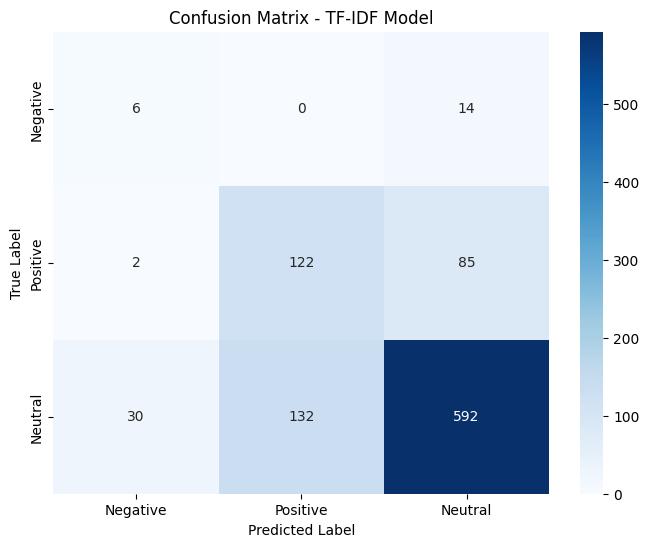

In [54]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# TF-IDF features
X_tfidf = tfidf_features

print(data['sentiment'].unique)
# Encode sentiment labels
data['sentiment_encoded'] = data['sentiment'].map({'positive': 1, 'negative': 0, 'neutral': 2})
y = data['sentiment_encoded']


# Split the data for TF-IDF model
X_tfidf_train, X_tfidf_test, y_tfidf_train, y_tfidf_test = train_test_split(
    X_tfidf, y, test_size=0.2, stratify=y, random_state=42
)

# Apply SMOTE to balance the training data
smote = SMOTE(random_state=42)
X_tfidf_train_balanced, y_tfidf_train_balanced = smote.fit_resample(X_tfidf_train, y_tfidf_train)

# Initialize and train the TF-IDF logistic regression model
tfidf_model = LogisticRegression(max_iter=1000, random_state=42)
tfidf_model.fit(X_tfidf_train_balanced, y_tfidf_train_balanced)

# Make predictions using TF-IDF model
y_tfidf_pred = tfidf_model.predict(X_tfidf_test)

# Evaluate the TF-IDF model
tfidf_accuracy = accuracy_score(y_tfidf_test, y_tfidf_pred)
print(f"TF-IDF Model Accuracy: {tfidf_accuracy}")

# Classification Report for TF-IDF model
print("TF-IDF Model Classification Report:")
print(classification_report(y_tfidf_test, y_tfidf_pred, 
                          target_names=['Negative', 'Positive', 'Neutral']))

# Confusion Matrix for TF-IDF model
tfidf_conf_matrix = confusion_matrix(y_tfidf_test, y_tfidf_pred)
print("TF-IDF Model Confusion Matrix:")
print(tfidf_conf_matrix)

# Visualize the TF-IDF confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(tfidf_conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=['Negative', 'Positive', 'Neutral'],
            yticklabels=['Negative', 'Positive', 'Neutral'])
plt.title("Confusion Matrix - TF-IDF Model")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

##### 3.2.2 Machine Learning : Logistic Regression with word2vec

In [55]:
from gensim.models import Word2Vec

# Prepare tokenized sentences
tokenized_sentences = data['processed_review'].fillna('').apply(lambda x: x.split())

# Train a Word2Vec model
word2vec_model = Word2Vec(sentences=tokenized_sentences, vector_size=100, window=5, min_count=2, workers=4)

# Generate sentence embeddings by averaging word vectors
def get_sentence_embedding(sentence):
    vectors = [word2vec_model.wv[word] for word in sentence if word in word2vec_model.wv]
    if len(vectors) > 0:
        return sum(vectors) / len(vectors)
    else:
        return [0] * 100  # Vector size

data['word2vec_embedding'] = tokenized_sentences.apply(get_sentence_embedding)
data.head(5)


,reviewText,overall,sentiment,sentiment_score,processed_review,abil,abl,absolut,accept,access,...,xp,xperia,ye,year,yet,youll,your,youv,zero,sentiment_encoded
0,No issues.,4.0,neutral,0.999660,issu,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,2
1,"Purchased this for my device, it worked as adv...",5.0,neutral,0.999040,purchas devic work advertis never much phone m...,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,2
2,it works as expected. I should have sprung for...,4.0,positive,0.998226,work expect sprung higher capac think made bit...,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1
3,This think has worked out great.Had a diff. br...,5.0,positive,0.998094,think work greathad diff bran gb card went sou...,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,1,1
4,"Bought it with Retail Packaging, arrived legit...",5.0,neutral,0.587625,bought retail packag arriv legit orang envelop...,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,1,0,0,0,2


Word2Vec Model Accuracy: 0.40488301119023395
Word2Vec Model Classification Report:
              precision    recall  f1-score   support

           0       0.05      0.61      0.09        23
           1       0.36      0.57      0.44       235
           2       0.79      0.35      0.48       725

    accuracy                           0.40       983
   macro avg       0.40      0.51      0.34       983
weighted avg       0.67      0.40      0.46       983

Word2Vec Model Confusion Matrix:
[[ 14   4   5]
 [ 42 133  60]
 [244 230 251]]


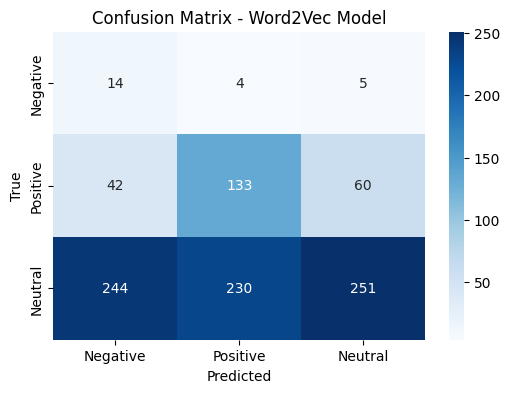

In [56]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Convert embeddings to a 2D NumPy array
X_w2v = np.vstack(data['word2vec_embedding'].values)

# Encode 'sentiment' column into numeric labels
data['sentiment_encoded'] = data['sentiment'].map({'positive': 1, 'negative': 0, 'neutral': 2})  
y = data['sentiment_encoded']

# Split the data for Word2Vec model
X_w2v_train, X_w2v_test, y_w2v_train, y_w2v_test = train_test_split(X_w2v, y, test_size=0.2, random_state=42)

# Apply SMOTE to balance the training data
smote = SMOTE(random_state=42)
X_w2v_train_balanced, y_w2v_train_balanced = smote.fit_resample(X_w2v_train, y_w2v_train)

# Initialize and train the Word2Vec logistic regression model
w2v_model = LogisticRegression(max_iter=1000)
w2v_model.fit(X_w2v_train_balanced, y_w2v_train_balanced)

# Make predictions using Word2Vec model
y_w2v_pred = w2v_model.predict(X_w2v_test)

# Evaluate the Word2Vec model
w2v_accuracy = accuracy_score(y_w2v_test, y_w2v_pred)
print(f"Word2Vec Model Accuracy: {w2v_accuracy}")

# Print Classification Report for Word2Vec model
print("Word2Vec Model Classification Report:")
print(classification_report(y_w2v_test, y_w2v_pred))

# Compute confusion matrix for Word2Vec model
w2v_conf_matrix = confusion_matrix(y_w2v_test, y_w2v_pred)
print("Word2Vec Model Confusion Matrix:")
print(w2v_conf_matrix)

# Visualize the Word2Vec confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(w2v_conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Negative', 'Positive', 'Neutral'], 
            yticklabels=['Negative', 'Positive', 'Neutral'])
plt.title('Confusion Matrix - Word2Vec Model')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

##### 3.2.3 Machine Learning : Logistic Regression with bag-of-words

BoW Model Accuracy: 0.6927772126144456
BoW Model Classification Report:
              precision    recall  f1-score   support

           0       0.18      0.26      0.21        23
           1       0.45      0.54      0.49       235
           2       0.82      0.76      0.79       725

    accuracy                           0.69       983
   macro avg       0.48      0.52      0.50       983
weighted avg       0.72      0.69      0.70       983

BoW Model Confusion Matrix:
[[  6   0  17]
 [  3 126 106]
 [ 25 151 549]]


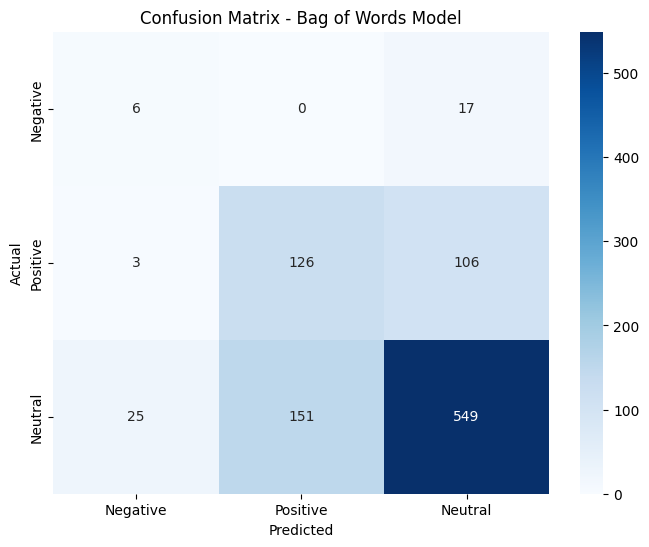

In [57]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE  # Import SMOTE for oversampling

# Initialize the CountVectorizer (Bag of Words)
bow_vectorizer = CountVectorizer(max_features=1000)  

# Fit and transform the 'processed_review' column
X_bow = bow_vectorizer.fit_transform(data['processed_review'].fillna('')).toarray()

# Encode the target labels
data['sentiment_encoded'] = data['sentiment'].map({'positive': 1, 'negative': 0, 'neutral': 2})  
y = data['sentiment_encoded']

# Split the data for BoW model
X_bow_train, X_bow_test, y_bow_train, y_bow_test = train_test_split(X_bow, y, test_size=0.2, random_state=42)

# Apply SMOTE to balance the training data
smote = SMOTE(random_state=42)
X_bow_train_balanced, y_bow_train_balanced = smote.fit_resample(X_bow_train, y_bow_train)

# Initialize and train the Logistic Regression model with BoW
bow_model = LogisticRegression(max_iter=1000, class_weight='balanced')
bow_model.fit(X_bow_train_balanced, y_bow_train_balanced)

# Make predictions using BoW model
y_bow_pred = bow_model.predict(X_bow_test)

# Evaluate the BoW model
bow_accuracy = accuracy_score(y_bow_test, y_bow_pred)
print(f"BoW Model Accuracy: {bow_accuracy}")

# Print classification report for BoW model
print("BoW Model Classification Report:")
print(classification_report(y_bow_test, y_bow_pred))

# Compute confusion matrix for BoW model
bow_conf_matrix = confusion_matrix(y_bow_test, y_bow_pred)
print("BoW Model Confusion Matrix:")
print(bow_conf_matrix)

# Plot confusion matrix for BoW model
plt.figure(figsize=(8, 6))
sns.heatmap(bow_conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Negative', 'Positive', 'Neutral'], 
            yticklabels=['Negative', 'Positive', 'Neutral'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix - Bag of Words Model')
plt.show()

#### Compare three models

In [58]:
import pandas as pd
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

def create_comparison_table(y_true_bow, y_pred_bow, 
                          y_true_w2v, y_pred_w2v,
                          y_true_tfidf, y_pred_tfidf):
    
    def get_all_metrics(y_true, y_pred):
        # Get all metrics
        precision, recall, f1, support = precision_recall_fscore_support(y_true, y_pred)
        accuracy = accuracy_score(y_true, y_pred)
        
        # Get macro and weighted averages
        macro_precision, macro_recall, macro_f1, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
        weighted_f1 = precision_recall_fscore_support(y_true, y_pred, average='weighted')[2]
        
        return {
            'Accuracy': accuracy,
            'Macro_F1': macro_f1,
            'Weighted_F1': weighted_f1,
            'Positive_Precision': precision[1],  # 80% class
            'Positive_Recall': recall[1],
            'Positive_F1': f1[1],
            'Negative_Precision': precision[0],  # 15% class
            'Negative_Recall': recall[0],
            'Negative_F1': f1[0],
            'Neutral_Precision': precision[2],   # 5% class
            'Neutral_Recall': recall[2],
            'Neutral_F1': f1[2]
        }
    
    # Get metrics for each model
    metrics = {
        'Bag of Words': get_all_metrics(y_true_bow, y_pred_bow),
        'Word2Vec': get_all_metrics(y_true_w2v, y_pred_w2v),
        'TF-IDF': get_all_metrics(y_true_tfidf, y_pred_tfidf)
    }
    
    # Create DataFrame with all metrics
    df = pd.DataFrame(metrics).round(3)
    
    # Add metric descriptions
    df.index = pd.MultiIndex.from_tuples([
        ('Overall Metrics', 'Accuracy'),
        ('Overall Metrics', 'Macro F1'),
        ('Overall Metrics', 'Weighted F1'),
        ('Positive Class ', 'Precision'),
        ('Positive Class ', 'Recall'),
        ('Positive Class', 'F1-score'),
        ('Negative Class', 'Precision'),
        ('Negative Class', 'Recall'),
        ('Negative Class', 'F1-score'),
        ('Neutral Class', 'Precision'),
        ('Neutral Class', 'Recall'),
        ('Neutral Class', 'F1-score')
    ])
    
    # Style the DataFrame for better visualization
    styled_df = df.style.background_gradient(cmap='YlOrRd')
    styled_df = styled_df.format("{:.3f}")
    
    return styled_df

# Create and display comparison table
comparison_table = create_comparison_table(
    y_bow_test, y_bow_pred,
    y_w2v_test, y_w2v_pred,
    y_tfidf_test, y_tfidf_pred
)

# Display the table
print("\nModel Comparison Table:")
display(comparison_table)

# Find best model for each metric
metrics_df = comparison_table.data
print("\nBest Model for Each Metric:")
for metric in metrics_df.index:
    best_model = metrics_df.loc[metric].idxmax()
    best_value = metrics_df.loc[metric].max()
    print(f"{metric[0]} - {metric[1]}: {best_model} ({best_value:.3f})")


Model Comparison Table:



Best Model for Each Metric:
Overall Metrics - Accuracy: TF-IDF (0.732)
Overall Metrics - Macro F1: TF-IDF (0.518)
Overall Metrics - Weighted F1: TF-IDF (0.745)
Positive Class  - Precision: TF-IDF (0.480)
Positive Class  - Recall: TF-IDF (0.584)
Positive Class - F1-score: TF-IDF (0.527)
Negative Class - Precision: Bag of Words (0.176)
Negative Class - Recall: Word2Vec (0.609)
Negative Class - F1-score: Bag of Words (0.211)
Neutral Class - Precision: TF-IDF (0.857)
Neutral Class - Recall: TF-IDF (0.785)
Neutral Class - F1-score: TF-IDF (0.819)


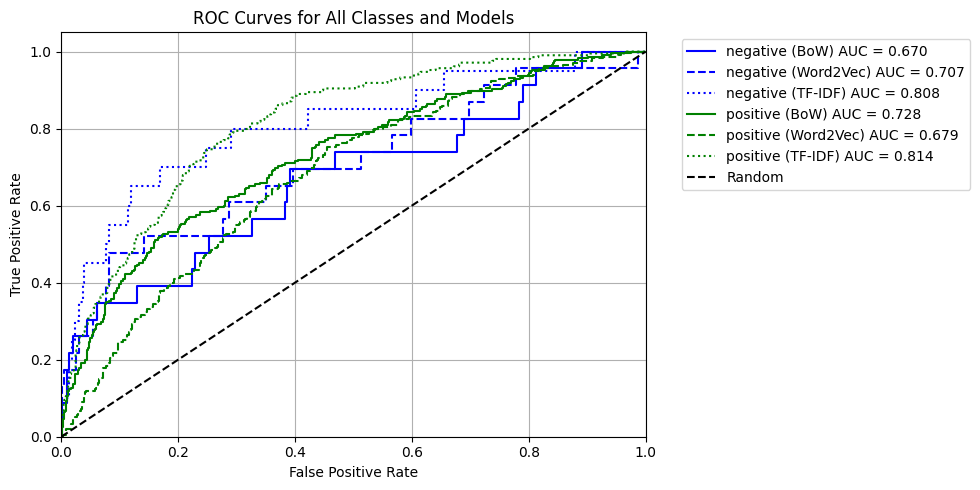

In [60]:
import numpy as np
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

def plot_roc_curves(y_test_bow, y_pred_proba_bow,
                   y_test_w2v, y_pred_proba_w2v,
                   y_test_tfidf, y_pred_proba_tfidf):
    
    # Simplified ROC plot focusing on minority classes only
    plt.figure(figsize=(10, 5))

    # Plot only Negative and Neutral classes
    classes = ['negative', 'positive']
    colors = ['blue', 'green']
    models = ['BoW', 'Word2Vec', 'TF-IDF']
    line_styles = ['-', '--', ':']
    
    # Plot ROC curve for each class and each model
    for i, class_name in enumerate(classes):
        # BoW
        fpr, tpr, _ = roc_curve(y_test_bow == i, y_pred_proba_bow[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, color=colors[i], linestyle=line_styles[0],
                label=f'{class_name} (BoW) AUC = {roc_auc:.3f}')
        
        # Word2Vec
        fpr, tpr, _ = roc_curve(y_test_w2v == i, y_pred_proba_w2v[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, color=colors[i], linestyle=line_styles[1],
                label=f'{class_name} (Word2Vec) AUC = {roc_auc:.3f}')
        
        # TF-IDF
        fpr, tpr, _ = roc_curve(y_test_tfidf == i, y_pred_proba_tfidf[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, color=colors[i], linestyle=line_styles[2],
                label=f'{class_name} (TF-IDF) AUC = {roc_auc:.3f}')
    
    # Add diagonal line
    plt.plot([0, 1], [0, 1], 'k--', label='Random')
    
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves for All Classes and Models')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Get probability predictions for each model
y_bow_proba = bow_model.predict_proba(X_bow_test)
y_w2v_proba = w2v_model.predict_proba(X_w2v_test)
y_tfidf_proba = tfidf_model.predict_proba(X_tfidf_test)

# Plot ROC curves
plot_roc_curves(y_bow_test, y_bow_proba,
                y_w2v_test, y_w2v_proba,
                y_tfidf_test, y_tfidf_proba)

**TF-IDF** emerges as the strongest performer across most metrics, especially when considering the imbalanced nature of the dataset. Here's why:

1. **Overall Performance:**
- TF-IDF achieves the highest accuracy (0.732) and strongest weighted F1-score (0.745)
- It also leads in macro F1-score (0.518), suggesting better balanced performance across classes

2. **Class-specific Performance:**
- For the majority Neutral class: TF-IDF excels with high precision (0.857) and recall (0.785), resulting in the best F1-score (0.819)
- For Positive class: TF-IDF shows moderate performance with recall at 0.584 and F1-score at 0.527
- For the minority Negative class: Performance is split across models, with BoW leading in precision (0.176) and Word2Vec in recall (0.609)

3. **ROC Analysis:**
- TF-IDF demonstrates superior AUC scores for both negative (0.808) and positive (0.814) classes
- The ROC curves show TF-IDF consistently outperforming other models across different classification thresholds

While there's room for improvement, particularly in handling the minority negative class, TF-IDF's balanced performance across metrics and classes makes it the most reliable choice for this **imbalanced classification** task.

### Test case

### Bag of Words

In [177]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
import pandas as pd

# Function to predict sentiment for a new review
def predict_sentiment_bow(review, model, vectorizer):
    # Transform the review using the trained CountVectorizer
    review_transformed = vectorizer.transform([review]).toarray()

    # Use the trained Logistic Regression model to predict sentiment
    prediction = model.predict(review_transformed)
    
    # Mapping the predicted label back to sentiment
    sentiment_map = {0: 'negative', 1: 'positive', 2: 'neutral'}
    return sentiment_map[prediction[0]]



In [192]:
# Example review
review = "I am extremely pleased with this purchase! The product is well-built and easy to use. It works exactly as advertised and has made my daily tasks much easier. The setup was straightforward, and the performance has been flawless so far. I especially love the thoughtful design and attention to detail. Customer service was also fantastic when I had a question. For the price, this product offers incredible value, and I would highly recommend it to anyone looking for a reliable solution"

# Predict sentiment using Bag of Words model
predicted_sentiment = predict_sentiment_bow(review, bow_model, bow_vectorizer)

print(f"Review: {review}")
print(f"Predicted Sentiment: {predicted_sentiment}")

Review: I am extremely pleased with this purchase! The product is well-built and easy to use. It works exactly as advertised and has made my daily tasks much easier. The setup was straightforward, and the performance has been flawless so far. I especially love the thoughtful design and attention to detail. Customer service was also fantastic when I had a question. For the price, this product offers incredible value, and I would highly recommend it to anyone looking for a reliable solution
Predicted Sentiment: Positive


In [193]:
# Example review
review = "I purchased this product hoping it would meet my expectations, but I was let down. The build quality feels cheap, and it started malfunctioning after only a few uses. The instructions were unclear, and I struggled to set it up properly. Additionally, the customer service was unresponsive when I reached out for support. I would not recommend this product to anyone, especially considering the price. Very disappointing experience overall"

# Predict sentiment using Bag of Words model
predicted_sentiment = predict_sentiment_bow(review, bow_model, bow_vectorizer)

print(f"Review: {review}")
print(f"Predicted Sentiment: {predicted_sentiment}")

Review: I purchased this product hoping it would meet my expectations, but I was let down. The build quality feels cheap, and it started malfunctioning after only a few uses. The instructions were unclear, and I struggled to set it up properly. Additionally, the customer service was unresponsive when I reached out for support. I would not recommend this product to anyone, especially considering the price. Very disappointing experience overall
Predicted Sentiment: Negative


In [194]:
# Example review
review = "The product gets the job done and is reasonably priced for what it offers. However, I had to return the first one and exchange it due to a defect. Sandisk should definitely improve the quality control of their products. Fortunately, the replacement works flawlessly. I use it with my GoPro camera, and it's been performing well since the swap"

# Predict sentiment using Bag of Words model
predicted_sentiment = predict_sentiment_bow(review, bow_model, bow_vectorizer)

print(f"Review: {review}")
print(f"Predicted Sentiment: {predicted_sentiment}")

Review: The product gets the job done and is reasonably priced for what it offers. However, I had to return the first one and exchange it due to a defect. Sandisk should definitely improve the quality control of their products. Fortunately, the replacement works flawlessly. I use it with my GoPro camera, and it's been performing well since the swap
Predicted Sentiment: Neutral


### 